In [11]:
import sys
sys.path.append('../..')

In [14]:
import json
import data
from eval_model import compute_accuracy
import pandas as pd

tag_vocab, _ = data.load_vocab('../../data/swda_tag_vocab.json')
test_data = data.load_data('../../data/swda_test.json', 'utts', 'tags')

with open('wordvec-avg.L/preds.E10.json') as f:
    preds_wva = json.load(f)
preds_wva = [[tag_vocab[t] for t in d] for d in preds_wva]

with open('bert.L/preds.E5.json') as f:
    preds_bert = json.load(f)
preds_bert = [[tag_vocab[t] for t in d] for d in preds_bert]

with open('wordvec-avg.NL/preds.E10.json') as f:
    preds_wva_nl = json.load(f)
preds_wva_nl = [[tag_vocab[t] for t in d] for d in preds_wva_nl]

with open('bert.NL/preds.E6.json') as f:
    preds_bert_nl = json.load(f)
preds_bert_nl = [[tag_vocab[t] for t in d] for d in preds_bert_nl]

In [12]:
df = []
for i, diag in enumerate(test_data):
    for j, (utt, tag) in enumerate(zip(*diag)):
        df.append(
            { 'diag_id': i
            , 'utt_id': j
            , 'utt': utt
            , 'tag': tag
            , 'pred_wva': preds_wva[i][j]
            , 'pred_bert': preds_bert[i][j]
            , 'pred_wva_nl': preds_wva_nl[i][j]
            , 'pred_bert_nl': preds_bert_nl[i][j]
            })
df = pd.DataFrame(df)
df['correct_wva'] = df.pred_wva == df.tag
df['correct_wva_nl'] = df.pred_wva_nl == df.tag
df['correct_bert'] = df.pred_bert == df.tag
df['correct_bert_nl'] = df.pred_bert_nl == df.tag

In [13]:
print("Wordvec-Avg accuracy (L)  {:.4f}".format(sum(df.correct_wva) / len(df)))
print("Wordvec-Avg accuracy (NL) {:.4f}".format(sum(df.correct_wva_nl) / len(df)))
print("Bert accuracy        (L)  {:.4f}".format(sum(df.correct_bert) / len(df)))
print("Bert accuracy        (NL) {:.4f}".format(sum(df.correct_bert_nl) / len(df)))

Wordvec-Avg accuracy (L)  0.7017
Wordvec-Avg accuracy (NL) 0.6981
Bert accuracy        (L)  0.7788
Bert accuracy        (NL) 0.7723


In [14]:
def scores(df, model):
    pred = 'pred' + '_' + model
    columns = [c + '_' + model for c in ['precision', 'recall', 'f1']]
    tp = df[df[pred] == df.tag].tag.value_counts()
    p  = df[pred].value_counts()
    pr = (tp / p).fillna(0)
    re = (tp / df.tag.value_counts()).fillna(0)
    f1 = (2 * (pr * re) / (pr + re)).fillna(0)
    return pd.DataFrame([pr, re, f1], index=columns).transpose()


In [15]:
sdf = pd.merge(scores(df, 'wva'), scores(df, 'bert'), left_index=True, right_index=True)
sdf = pd.merge(sdf, scores(df, 'wva_nl'), left_index=True, right_index=True)
sdf = pd.merge(sdf, scores(df, 'bert_nl'), left_index=True, right_index=True)

sdf['tag_count'] = df.tag.value_counts()
sdf['f1_diff_bert_wva'] = sdf.f1_bert - sdf.f1_wva
sdf['f1_diff_wva_nl'] = sdf.f1_wva - sdf.f1_wva_nl
sdf['f1_diff_bert_nl'] = sdf.f1_bert - sdf.f1_bert_nl
f1_cols = ['tag_count', 'f1_bert', 'f1_bert_nl', 'f1_wva', 'f1_wva_nl', 'f1_diff_bert_wva', 'f1_diff_wva_nl', 'f1_diff_bert_nl']

In [6]:
sdf = sdf.sort_values('f1_diff_bert_wva', ascending=False)
sdf[f1_cols].head(10)

,tag_count,f1_bert,f1_bert_nl,f1_wva,f1_wva_nl,f1_diff_bert_wva,f1_diff_wva_nl,f1_diff_bert_nl
fp,69,0.779661,0.786885,0.000000,0.000000,0.779661,0.000000,-0.007224
h,230,0.746204,0.774194,0.000000,0.000000,0.746204,0.000000,-0.027990
qo,135,0.746032,0.637555,0.000000,0.000000,0.746032,0.000000,0.108477
"fo/o/fw/""/by/bc",169,0.664311,0.618893,0.000000,0.577778,0.664311,-0.577778,0.045418
fa,12,0.600000,0.444444,0.000000,0.000000,0.600000,0.000000,0.155556
qrr,43,0.582278,0.192308,0.000000,0.000000,0.582278,0.000000,0.389971
qw,361,0.811321,0.769420,0.287850,0.409861,0.523470,-0.122011,0.041900
bk,242,0.536697,0.496454,0.054264,0.298851,0.482434,-0.244587,0.040243
ad,189,0.398625,0.441472,0.000000,0.000000,0.398625,0.000000,-0.042846
^h,72,0.361905,0.450450,0.000000,0.000000,0.361905,0.000000,-0.088546


In [7]:
sdf = sdf.sort_values('f1_diff_wva_nl', ascending=False)
sdf[f1_cols].head(10)

,tag_count,f1_bert,f1_bert_nl,f1_wva,f1_wva_nl,f1_diff_bert_wva,f1_diff_wva_nl,f1_diff_bert_nl
fc,580,0.750000,0.750442,0.573840,0.517316,0.176160,0.056524,-0.000442
bh,221,0.766440,0.726437,0.622449,0.587927,0.143991,0.034522,0.040003
+,3575,0.883608,0.904035,0.727625,0.695283,0.155983,0.032342,-0.020426
fx/sv,5399,0.633404,0.580528,0.576644,0.549779,0.056760,0.026865,0.052876
na,162,0.340136,0.386861,0.031250,0.011905,0.308886,0.019345,-0.046725
fe/ba,927,0.736358,0.711951,0.573302,0.557399,0.163057,0.015903,0.024407
%,3112,0.806894,0.788073,0.701906,0.686722,0.104988,0.015184,0.018821
x,651,0.979561,0.981046,0.869695,0.857143,0.109866,0.012552,-0.001485
sd,14882,0.838227,0.835305,0.792555,0.786595,0.045672,0.005960,0.002922
t1,21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
sdf = sdf.sort_values('f1_diff_bert_nl', ascending=False)
sdf[f1_cols].head(10)

,tag_count,f1_bert,f1_bert_nl,f1_wva,f1_wva_nl,f1_diff_bert_wva,f1_diff_wva_nl,f1_diff_bert_nl
qrr,43,0.582278,0.192308,0.000000,0.000000,0.582278,0.000000,0.389971
fa,12,0.600000,0.444444,0.000000,0.000000,0.600000,0.000000,0.155556
qo,135,0.746032,0.637555,0.000000,0.000000,0.746032,0.000000,0.108477
fx/sv,5399,0.633404,0.580528,0.576644,0.549779,0.056760,0.026865,0.052876
no,58,0.289855,0.238806,0.000000,0.000000,0.289855,0.000000,0.051049
"fo/o/fw/""/by/bc",169,0.664311,0.618893,0.000000,0.577778,0.664311,-0.577778,0.045418
aa,2387,0.529521,0.485957,0.359533,0.395844,0.169988,-0.036311,0.043564
qw,361,0.811321,0.769420,0.287850,0.409861,0.523470,-0.122011,0.041900
^q,206,0.087591,0.046332,0.000000,0.000000,0.087591,0.000000,0.041259
bk,242,0.536697,0.496454,0.054264,0.298851,0.482434,-0.244587,0.040243


In [25]:
sdf = sdf.sort_values('tag_count', ascending=False)
sdf[f1_cols]

,tag_count,f1_bert,f1_bert_nl,f1_wva,f1_wva_nl,f1_diff_bert_wva,f1_diff_wva_nl,f1_diff_bert_nl
sd,14882,0.838227,0.835305,0.792555,0.786595,0.045672,0.005960,0.002922
b,7763,0.862990,0.867476,0.839909,0.841497,0.023081,-0.001588,-0.004486
fx/sv,5399,0.633404,0.580528,0.576644,0.549779,0.056760,0.026865,0.052876
+,3575,0.883608,0.904035,0.727625,0.695283,0.155983,0.032342,-0.020426
%,3112,0.806894,0.788073,0.701906,0.686722,0.104988,0.015184,0.018821
aa,2387,0.529521,0.485957,0.359533,0.395844,0.169988,-0.036311,0.043564
fe/ba,927,0.736358,0.711951,0.573302,0.557399,0.163057,0.015903,0.024407
qr/qy,868,0.793028,0.767762,0.547170,0.574227,0.245859,-0.027057,0.025266
x,651,0.979561,0.981046,0.869695,0.857143,0.109866,0.012552,-0.001485
fc,580,0.750000,0.750442,0.573840,0.517316,0.176160,0.056524,-0.000442


In [10]:
pd.crosstab(df.tag, df.pred_wva)

pred_wva,%,+,aa,b,bh,bk,fc,fe/ba,"fo/o/fw/""/by/bc",fx/sv,na,nn,ny,qo,qr/qy,qw,sd,x
tag,,,,,,,,,,,,,,,,,,
%,2191,165,45,247,0,0,6,5,0,86,0,1,10,0,1,1,346,8
+,82,2817,25,33,0,0,2,8,0,196,1,0,0,0,26,8,374,3
^2,15,22,10,14,1,0,1,1,0,26,0,0,0,0,2,0,39,5
^g,0,0,1,4,3,0,0,0,0,0,0,0,0,0,8,0,0,0
^h,16,2,3,1,0,0,2,4,0,7,1,3,3,0,0,0,28,2
^q,5,7,3,5,0,0,0,5,0,39,0,0,0,0,8,0,132,2
aa,49,56,677,1228,0,1,2,51,0,142,0,5,27,0,0,0,138,11
aap/am,0,1,4,0,0,0,1,0,0,5,0,0,0,0,0,0,2,0
ad,5,19,3,3,0,0,4,4,1,22,0,0,1,0,14,1,111,1


In [11]:
pd.crosstab(df.tag, df.pred_bert)

pred_bert,%,+,^2,^h,^q,aa,ad,ar,b,b^m,...,oo/co/cc,qh,qo,qr/qy,qrr,qw,qy^d,sd,t1,x
tag,,,,,,,,,,,,,,,,,,,,,
%,2411,31,4,1,0,38,1,0,243,1,...,0,7,1,16,0,5,2,258,0,8
+,35,3105,7,1,0,10,2,0,26,6,...,0,3,0,21,0,4,4,241,0,3
^2,7,23,24,0,0,3,1,0,4,3,...,0,0,0,3,0,0,0,44,0,0
^g,0,0,0,0,0,2,0,0,3,0,...,0,0,0,3,0,0,0,0,0,0
^h,5,0,0,19,1,2,0,0,2,0,...,0,1,0,0,0,0,0,28,0,0
^q,1,2,0,0,12,3,5,0,3,1,...,0,7,0,8,0,1,1,119,0,1
aa,5,4,9,1,1,1139,1,0,966,0,...,0,0,0,0,0,0,0,101,0,0
aap/am,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
ad,1,2,3,1,8,1,58,0,0,0,...,1,3,0,8,0,0,1,67,0,0


In [22]:
(df[df.correct_wva & ~df.correct_wva_nl].tag.value_counts() / df.tag.value_counts()).sort_values(ascending=False)

+                  0.157483
x                  0.107527
fe/ba              0.101402
fx/sv              0.092239
fc                 0.067241
bh                 0.063348
qw                 0.060942
%                  0.042416
aa                 0.038123
qr/qy              0.036866
nn                 0.027451
ny                 0.023214
b                  0.021770
na                 0.018519
sd                 0.011826
bk                 0.004132
^2                      NaN
^g                      NaN
^h                      NaN
^q                      NaN
aap/am                  NaN
ad                      NaN
ar                      NaN
arp/nd                  NaN
b^m                     NaN
bd                      NaN
bf                      NaN
br                      NaN
fa                      NaN
fo/o/fw/"/by/bc         NaN
fp                      NaN
ft                      NaN
h                       NaN
ng                      NaN
no                      NaN
oo/co/cc            

In [24]:
(df[df.correct_bert & ~df.correct_bert_nl].tag.value_counts() / df.tag.value_counts()).sort_values(ascending=False)

qrr                0.488372
qo                 0.170370
fx/sv              0.162808
bk                 0.123967
qh                 0.122137
aa                 0.117302
fa                 0.083333
bh                 0.081448
^2                 0.073529
no                 0.068966
br                 0.068182
ad                 0.063492
ng                 0.060606
na                 0.055556
+                  0.054545
%                  0.053021
qr/qy              0.052995
ny                 0.048214
qw                 0.047091
^q                 0.043689
qy^d               0.039526
nn                 0.039216
h                  0.030435
fp                 0.028986
sd                 0.028894
b                  0.020482
fe/ba              0.015102
fc                 0.013793
fo/o/fw/"/by/bc    0.011834
b^m                0.006250
x                  0.001536
^g                      NaN
^h                      NaN
aap/am                  NaN
ar                      NaN
arp/nd              

In [26]:
a = (df[df.correct_bert & ~df.correct_wva].tag.value_counts() / df.tag.value_counts()).sort_values(ascending=False)

In [35]:
sdf['bert_wva_acc_diff'] = a

In [40]:
sdf.head(1)

,precision_wva,recall_wva,f1_wva,precision_bert,recall_bert,f1_bert,precision_wva_nl,recall_wva_nl,f1_wva_nl,precision_bert_nl,recall_bert_nl,f1_bert_nl,tag_count,f1_diff_bert_wva,f1_diff_wva_nl,f1_diff_bert_nl,bert_wva_acc_diff
sd,0.754957,0.834095,0.792555,0.799805,0.880527,0.838227,0.713154,0.876898,0.786595,0.778223,0.901425,0.835305,14882,0.045672,0.00596,0.002922,0.095888


In [ ]:
sdf[['bert_wva_acc_diff', 'tag_count', '']]

accuarcy specifically on utterances containing laughter

In [47]:
df_l = df[df.utt.apply(lambda x: '<laughter>' in x)]

In [52]:
df_l

,diag_id,pred_bert,pred_bert_nl,pred_wva,pred_wva_nl,tag,utt,utt_id,correct_wva,correct_wva_nl,correct_bert,correct_bert_nl,bert_wva_acc_diff
16,0,ny,ny,ny,ny,ny,[SPKR_A] yeah <laughter> . /,16,True,True,True,True,NaN
38,0,qr/qy,bh,x,qr/qy,qr/qy,[SPKR_A] do you ? <laughter> . /,38,False,True,True,False,NaN
50,0,x,x,x,x,x,[SPKR_B] <laughter> .,50,True,True,True,True,NaN
67,0,no,sd,sd,sd,sd,"[SPKR_B] <lipsmack> {f uh , } i do n't even kn...",67,True,True,False,True,NaN
72,0,+,+,+,+,+,[SPKR_B] - - to donahue <laughter> . /,72,True,True,True,True,NaN
79,0,b,b,b,b,b,[SPKR_A] yeah <laughter> . /,79,True,True,True,True,NaN
82,0,aa,aa,x,aa,aa,[SPKR_A] that 's right <laughter> . /,82,False,True,True,True,NaN
83,0,fx/sv,fx/sv,+,sd,fx/sv,[SPKR_B] they 're stupid <laughter> . /,83,False,False,True,True,NaN
99,0,%,%,%,%,%,"[SPKR_B] {d so } <laughter> , -/",99,True,True,True,True,NaN
109,0,x,x,x,x,x,[SPKR_B] <laughter> .,109,True,True,True,True,NaN


In [53]:
print("Wordvec-Avg accuracy (L)  {:.4f}".format(sum(df_l.correct_wva) / len(df_l)))
print("Wordvec-Avg accuracy (NL) {:.4f}".format(sum(df_l.correct_wva_nl) / len(df_l)))
print("Bert accuracy        (L)  {:.4f}".format(sum(df_l.correct_bert) / len(df_l)))
print("Bert accuracy        (NL) {:.4f}".format(sum(df_l.correct_bert_nl) / len(df_l)))

Wordvec-Avg accuracy (L)  0.7025
Wordvec-Avg accuracy (NL) 0.6783
Bert accuracy        (L)  0.7681
Bert accuracy        (NL) 0.7588


In [56]:
df.head(2)

,diag_id,pred_bert,pred_bert_nl,pred_wva,pred_wva_nl,tag,utt,utt_id,correct_wva,correct_wva_nl,correct_bert,correct_bert_nl,bert_wva_acc_diff,prev_utt
0,0,fp,fp,qw,qw,fp,[SPKR_A] hello ? /,0,False,False,True,True,NaN,-1
1,0,fp,fp,ny,ny,fp,[SPKR_B] hi . /,1,False,False,True,True,NaN,0


In [85]:
df['prev_utt'] = df['utt_id'] - 1

df_p1 = pd.merge(df, df, how='outer', left_on=['diag_id', 'utt_id'], right_on=['diag_id', 'prev_utt'], suffixes=('_1', '_2')).dropna()

df_p1_l = df_p1[df_p1.utt_1.apply(lambda x: '<laughter>' in x)]

print("Wordvec-Avg accuracy (L)  {:.4f}".format(sum(df_p1_l.correct_wva_2) / len(df_p1_l)))
print("Wordvec-Avg accuracy (NL) {:.4f}".format(sum(df_p1_l.correct_wva_nl_2) / len(df_p1_l)))
print("Bert accuracy        (L)  {:.4f}".format(sum(df_p1_l.correct_bert_2) / len(df_p1_l)))
print("Bert accuracy        (NL) {:.4f}".format(sum(df_p1_l.correct_bert_nl_2) / len(df_p1_l)))

Wordvec-Avg accuracy (L)  0.6503
Wordvec-Avg accuracy (NL) 0.6439
Bert accuracy        (L)  0.7611
Bert accuracy        (NL) 0.7374


In [86]:
df['prev_utt'] = df['utt_id'] - 1

df_p1 = pd.merge(df, df, how='outer', left_on=['diag_id', 'utt_id'], right_on=['diag_id', 'prev_utt'], suffixes=('_1', '_2')).dropna()

df_p1_l = df_p1[df_p1.utt_2.apply(lambda x: '<laughter>' in x)]

print("Wordvec-Avg accuracy (L)  {:.4f}".format(sum(df_p1_l.correct_wva_1) / len(df_p1_l)))
print("Wordvec-Avg accuracy (NL) {:.4f}".format(sum(df_p1_l.correct_wva_nl_1) / len(df_p1_l)))
print("Bert accuracy        (L)  {:.4f}".format(sum(df_p1_l.correct_bert_1) / len(df_p1_l)))
print("Bert accuracy        (NL) {:.4f}".format(sum(df_p1_l.correct_bert_nl_1) / len(df_p1_l)))

Wordvec-Avg accuracy (L)  0.7025
Wordvec-Avg accuracy (NL) 0.6896
Bert accuracy        (L)  0.7675
Bert accuracy        (NL) 0.7521


In [9]:
import data
for split in ('train', 'test', 'val'):
    d = data.load_data('data/swda_{}.json'.format(split), 'utts', 'tags')
    diags = len(d)
    utts = sum([len(diag[0]) for diag in d])
    print('{} dialogues: {} utterances: {}'.format(split, diags, utts))

train dialogues: 808 utterances: 156441
test dialogues: 232 utterances: 44350
val dialogues: 115 utterances: 20825


232

44350

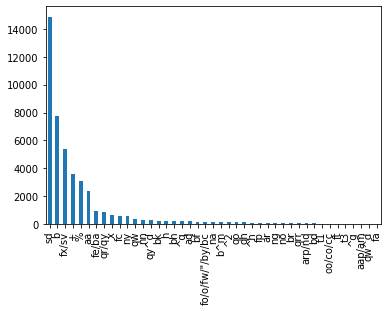

In [20]:
import matplotlib.pyplot as plt 
df.tag.value_counts().plot(kind='bar', stacked=True)

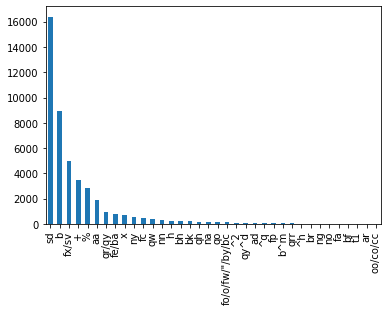

In [78]:
import matplotlib.pyplot as plt 
df.pred_bert.value_counts().plot(kind='bar', stacked=True)

In [114]:
df.pred_bert.value_counts()
a = df[['tag', 'pred_bert', 'pred_wva']].apply(pd.Series.value_counts).sort_values('tag', ascending=False)

In [115]:
a

,tag,pred_bert,pred_wva
sd,14882,16384.0,16442.0
b,7763,8900.0,9777.0
fx/sv,5399,4983.0,5502.0
+,3575,3453.0,4168.0
%,3112,2864.0,3131.0
aa,2387,1915.0,1379.0
fe/ba,927,814.0,751.0
qr/qy,868,968.0,1146.0
x,651,670.0,692.0
fc,580,452.0,368.0


In [118]:
a = a.head(10)

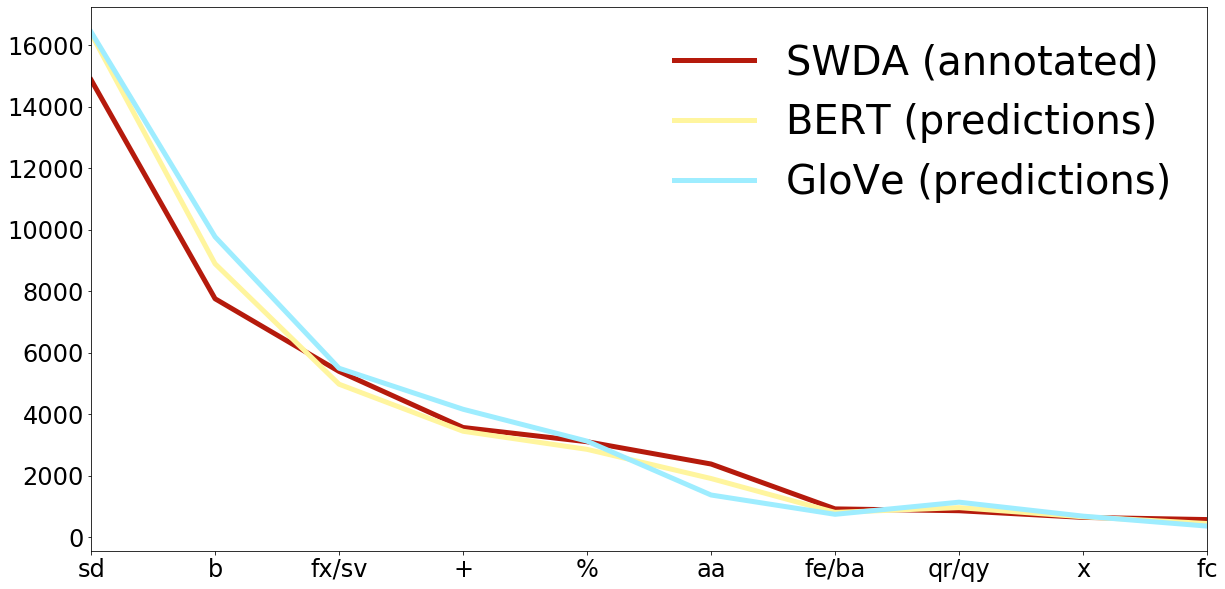

In [125]:
p = a.plot(figsize=(20,10), fontsize=24, 
                colors=['#b51a0c','#fff59e','#9eedff'], 
                linewidth=5, stacked=False)
ax = plt.gca()
# ax.set_yticklabels(['', '10k', '20k', '30k', '40k', '50k'])
plt.legend(['SWDA (annotated)', 'BERT (predictions)', 'GloVe (predictions)'], loc=1, prop={'size': 40}, frameon=False, markerscale=100)
plt.savefig("tag-freq.svg")

['sd',
 'b',
 'fx/sv',
 '+',
 '%',
 'aa',
 'fe/ba',
 'qr/qy',
 'x',
 'fc',
 'ny',
 'qw',
 'nn',
 'qy^d',
 'bk',
 'h',
 'bh',
 '^q',
 'ad',
 'bf']

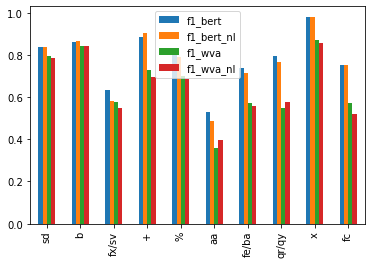

In [137]:
sdf = sdf.sort_values('tag_count', ascending=False)
sdf.head(10)[['f1_bert', 'f1_bert_nl', 'f1_wva', 'f1_wva_nl']].plot.bar()

In [143]:
df.groupby('tag')[['correct_wva', 'correct_wva_nl', 'correct_bert', 'correct_bert_nl']]

/Users/xnobwi/.virtualenvs/dia-bert/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


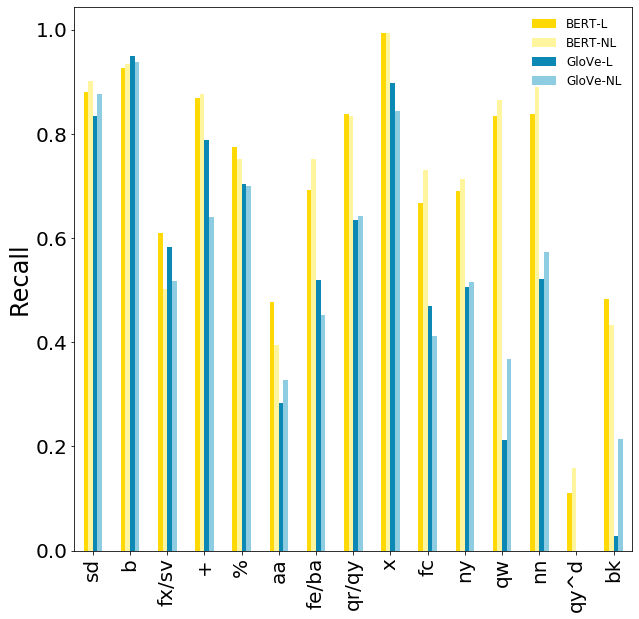

In [177]:
sdf = sdf.sort_values('tag_count', ascending=False)
sdf.head(15)[[ 'recall_bert','recall_bert_nl', 'recall_wva', 'recall_wva_nl']].plot.bar(
                figsize=(10,10), fontsize=20, 
                colors=['#ffd905', '#fff59e','#0c88b5','#8ecce2'], 
                linewidth=5, )
plt.legend(['BERT-L', 'BERT-NL', 'GloVe-L', 'GloVe-NL'], loc=0, prop={'size': 12}, frameon=False, markerscale=100)
plt.ylabel('Recall', size=24)
plt.savefig('recall-tags.pdf')

In [162]:
sdf.tag_count / sdf.tag_count.sum()
['statement non-opinion (0.34)'
, 'backchannel (0.18)'
, 'statement-opinion (0.12)'
, 'continuation (0.08)'
, 'abandoned turn (0.05)'
, '']

sd                 0.335558
b                  0.175039
fx/sv              0.121736
+                  0.080609
%                  0.070169
aa                 0.053822
fe/ba              0.020902
qr/qy              0.019572
x                  0.014679
fc                 0.013078
ny                 0.012627
qw                 0.008140
nn                 0.005750
qy^d               0.005705
bk                 0.005457
h                  0.005186
bh                 0.004983
^q                 0.004645
ad                 0.004262
bf                 0.003878
fo/o/fw/"/by/bc    0.003811
na                 0.003653
b^m                0.003608
^2                 0.003067
qo                 0.003044
qh                 0.002954
^h                 0.001623
fp                 0.001556
ar                 0.001533
ng                 0.001488
no                 0.001308
br                 0.000992
qrr                0.000970
arp/nd             0.000924
bd                 0.000699
t1                 0

In [147]:
sdf[['recall_wva', 'recall_bert', 'recall_wva_nl', 'recall_bert_nl']].mean()

recall_wva        0.197678
recall_bert       0.400203
recall_wva_nl     0.209271
recall_bert_nl    0.408121
dtype: float64

In [148]:
sdf[['precision_wva', 'precision_bert', 'precision_wva_nl', 'precision_bert_nl']].mean()

precision_wva        0.541169
precision_bert       0.592044
precision_wva_nl     0.633687
precision_bert_nl    0.582618
dtype: float64

In [179]:
sdf[['f1_wva', 'f1_bert', 'f1_wva_nl', 'f1_bert_nl']].mean()

,f1_wva,f1_bert,f1_wva_nl,f1_bert_nl
sd,0.792555,0.838227,0.786595,0.835305
b,0.839909,0.862990,0.841497,0.867476
fx/sv,0.576644,0.633404,0.549779,0.580528
+,0.727625,0.883608,0.695283,0.904035
%,0.701906,0.806894,0.686722,0.788073
aa,0.359533,0.529521,0.395844,0.485957
fe/ba,0.573302,0.736358,0.557399,0.711951
qr/qy,0.547170,0.793028,0.574227,0.767762
x,0.869695,0.979561,0.857143,0.981046
fc,0.573840,0.750000,0.517316,0.750442


In [178]:
sdf

,precision_wva,recall_wva,f1_wva,precision_bert,recall_bert,f1_bert,precision_wva_nl,recall_wva_nl,f1_wva_nl,precision_bert_nl,recall_bert_nl,f1_bert_nl,tag_count,f1_diff_bert_wva,f1_diff_wva_nl,f1_diff_bert_nl
sd,0.754957,0.834095,0.792555,0.799805,0.880527,0.838227,0.713154,0.876898,0.786595,0.778223,0.901425,0.835305,14882,0.045672,0.005960,0.002922
b,0.753401,0.948860,0.839909,0.807865,0.926188,0.862990,0.762802,0.938297,0.841497,0.809280,0.934690,0.867476,7763,0.023081,-0.001588,-0.004486
fx/sv,0.571247,0.582145,0.576644,0.659843,0.609002,0.633404,0.585637,0.518059,0.549779,0.686205,0.503056,0.580528,5399,0.056760,0.026865,0.052876
+,0.675864,0.787972,0.727625,0.899218,0.868531,0.883608,0.759443,0.641119,0.695283,0.932244,0.877483,0.904035,3575,0.155983,0.032342,-0.020426
%,0.699776,0.704049,0.701906,0.841830,0.774743,0.806894,0.673463,0.700514,0.686722,0.828258,0.751607,0.788073,3112,0.104988,0.015184,0.018821
aa,0.490935,0.283620,0.359533,0.594778,0.477168,0.529521,0.500962,0.327189,0.395844,0.631191,0.395057,0.485957,2387,0.169988,-0.036311,0.043564
fe/ba,0.640479,0.518878,0.573302,0.787469,0.691478,0.736358,0.724138,0.453074,0.557399,0.676043,0.751888,0.711951,927,0.163057,0.015903,0.024407
qr/qy,0.480803,0.634793,0.547170,0.752066,0.838710,0.793028,0.519590,0.641705,0.574227,0.711198,0.834101,0.767762,868,0.245859,-0.027057,0.025266
x,0.843931,0.897081,0.869695,0.965672,0.993856,0.979561,0.871429,0.843318,0.857143,0.968563,0.993856,0.981046,651,0.109866,0.012552,-0.001485
fc,0.739130,0.468966,0.573840,0.856195,0.667241,0.750000,0.694767,0.412069,0.517316,0.770909,0.731034,0.750442,580,0.176160,0.056524,-0.000442
